Table of Contents:  
1. Import libraries and data.
2. Create a subset of the time-series data.
3. Line chart.
4. Time-series analysis: decomposition.
5. Test for stationarity.
6. Autocorrelations.
7. Bonus task.  

1. Import libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature.

plt.style.use('fivethirtyeight') # This is a styling option for how plots will appear. 

In this step, I am importing the U.S. Total Vehicle Sales dataset by loading a CSV file that I downloaded directly from the Federal Reserve (FRED) website. I’m using pandas.read_csv() because the dataset is no longer available through the old Quandl API, so downloading the file manually is the most reliable method.

In [6]:
data = pd.read_csv("TOTALSA.csv")

In [7]:
data.head(5)

,observation_date,TOTALSA
0,1976-01-01,12.814
1,1976-02-01,13.340
2,1976-03-01,13.378
3,1976-04-01,13.223
4,1976-05-01,12.962


In [8]:
data.shape

(596, 2)

In [9]:
data.columns

Index(['observation_date', 'TOTALSA'], dtype='object')

In [11]:
type(data)

pandas.core.frame.DataFrame

2. Create a subset of the time-series data

In [12]:
# Reset index to make 'observation_date' a normal column
data_reset = data.reset_index()

In [13]:
# Convert dates to datetime format
data_reset['observation_date'] = pd.to_datetime(data_reset['observation_date'])

In [14]:
# Create subset from January 2000 to the most recent non-forecast date
data_sub = data_reset.loc[(data_reset['observation_date'] >= '2000-01-01')]

In [15]:
# Set date back as index for time series analysis
data_sub = data_sub.set_index('observation_date')

In [16]:
# Quick check
data_sub.head(), data_sub.tail()

(                  index  TOTALSA
 observation_date                
 2000-01-01          288   18.635
 2000-02-01          289   19.401
 2000-03-01          290   18.343
 2000-04-01          291   17.939
 2000-05-01          292   17.943,
                   index  TOTALSA
 observation_date                
 2025-04-01          591   17.590
 2025-05-01          592   16.067
 2025-06-01          593   16.042
 2025-07-01          594   16.896
 2025-08-01          595   16.802)

# Note on data range (2000-2025)

For this analysis, I decided to subset the U.S. Total Vehicle Sales data so that it includes only observations from January 2000 onward. My broader project focuses on Tesla and the growth of electric vehicle adoption, so including very early historical years (e.g., the 1970s–1990s) would not be meaningful for the research question.

Before 2000, the automotive industry operated in a completely different technological and economic environment, and there was no EV market to influence or compare to. Keeping those older values in the series could create misleading patterns in the trend and seasonality components during decomposition.


FRED’s Total Vehicle Sales (TOTALSA) series provides monthly, seasonally adjusted values. At the time of data collection (November 2025), the most recent official observation available in FRED is August 2025, reported on October 3, 2025. Therefore, the values in the dataset for 2024–2025 are not forecasted — they are the latest actual published observations from the Federal Reserve Bank of St. Louis.

3. Line chart

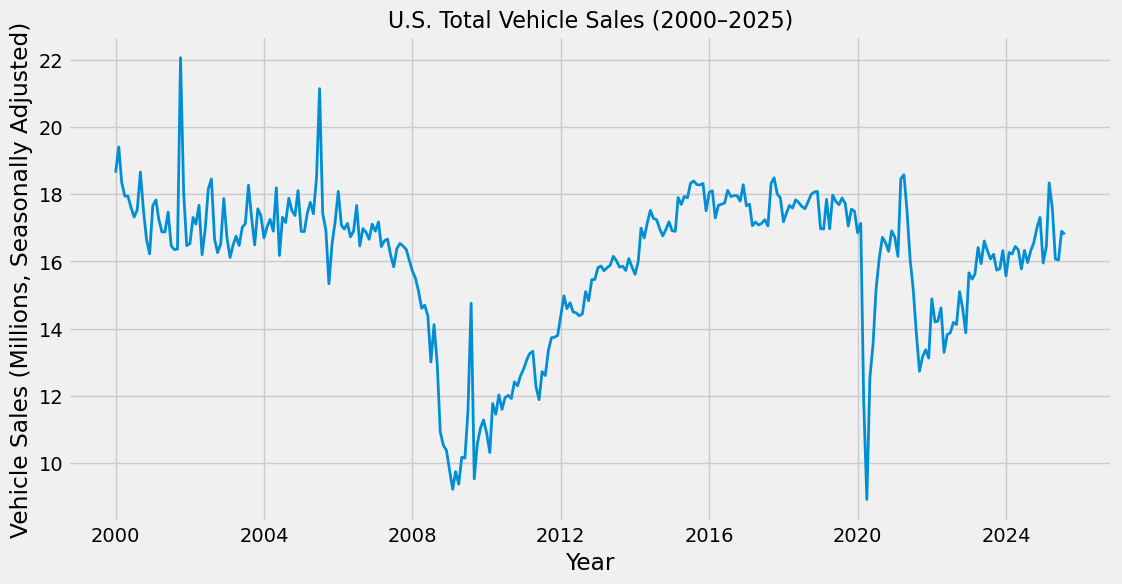

In [17]:
# Create line chart for U.S Total Vehicle Sales (
plt.figure(figsize=(12, 6))
plt.plot(data_sub.index, data_sub['TOTALSA'], linewidth=2)

plt.title("U.S. Total Vehicle Sales (2000–2025)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Vehicle Sales (Millions, Seasonally Adjusted)")
plt.grid(True)

plt.savefig("vehicle_sales_line_chart.png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# Check for missing values
data_sub.isnull().sum() 

index      0
TOTALSA    0
dtype: int64

In [19]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()

np.int64(0)

4. Time-series analysis: decomposition

<Figure size 1400x1000 with 0 Axes>

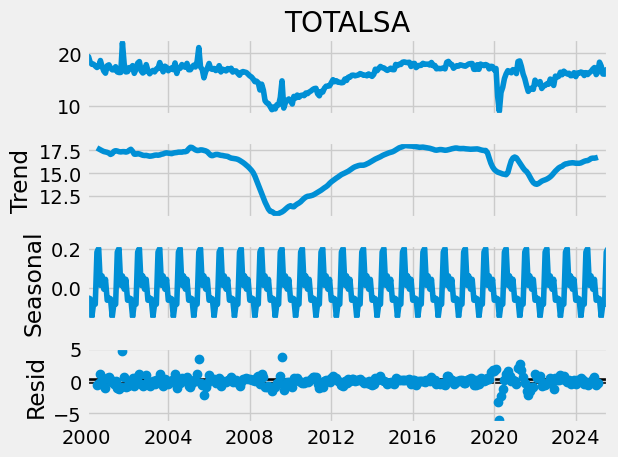

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition using an additive model
decomposition = seasonal_decompose(data_sub['TOTALSA'], model='additive', period=12)

# Plot decomposition
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.savefig("vehicle_sales_decomposition.png", dpi=300)
plt.show()

**Seasonal decomposition analysis**

To better understand the structure of the U.S. Total Vehicle Sales time series, I applied an additive seasonal decomposition. This method separates the series into three components:

**Trend**: long-term movement over time

**Seasonality**: repeating patterns occurring at regular intervals

**Residual**: random fluctuations unexplained by trend or seasonality

**Trend Component**

The trend line shows clear long-term shifts in vehicle sales:

- A gradual decline from the early 2000s into the 2008–2009 recession.

- A sharp drop during the financial crisis (2008–2009), where sales reached their lowest point.

- A strong recovery and steady growth from 2010 to around 2016.

- Pandemic disruption around 2020, with an abrupt collapse followed by a rapid rebound.

- More moderate, slightly fluctuating levels after 2021.

Overall, the trend captures major economic events that affected consumer demand for vehicles.

**Seasonal Component**

The seasonal component displays a consistent repeating annual pattern, meaning that certain months tend to have predictable highs and lows.


- Some months show higher sales, likely tied to model releases, tax timing, or year-end promotions.

- Other months show lower activity, possibly reflecting post-holiday periods or slower buying seasons.

- The repeatability of this pattern confirms that seasonality is present and stable over time.

**Residual Component**

The residual captures irregular movements not explained by trend or seasonality.

Notable spikes occur during:

- The 2008 financial crisis

- The COVID-19 pandemic (2020)

These events caused extreme deviations, suggesting strong external shocks. Outside these periods, most residual values fluctuate within a normal range.

5. Test for stationarity

In [25]:
from statsmodels.tsa.stattools import adfuller   # Import the adfuller() function

# Define the Dickey-Fuller test function
def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationarity test:')
    
    # Perform the test
    test = adfuller(timeseries, autolag='AIC')
    
    # Organize results
    result = pd.Series(test[0:4], index=[
        'Test Statistic', 
        'p-value', 
        'Number of Lags Used', 
        'Number of Observations Used'
    ])
    
    # Add critical values
    for key, value in test[4].items():
        result[f'Critical Value ({key})'] = value
    
    print(result)

# Apply test to my time series
dickey_fuller(data_sub['TOTALSA'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.942976
p-value                          0.040574
Number of Lags Used              2.000000
Number of Observations Used    305.000000
Critical Value (1%)             -3.451974
Critical Value (5%)             -2.871063
Critical Value (10%)            -2.571844
dtype: float64


**Dickey-Fuller Test Interpretation**

Null Hypothesis (H₀): The series has a unit root → it is non-stationary.

Alternative Hypothesis (H₁): The series does not have a unit root → it is stationary.

**Test Results**:

Test Statistic: –2.942976

p-value: 0.040574

Critical Value (5%): –2.871063

**Interpretation**:

The test statistic (-2.94) is lower (more negative) than the 5% critical value (-2.87).
Also, the p-value is approximately 0.040, which is less than 0.05.

This means we can reject the null hypothesis at the 5% significance level.

**Conclusion**

Based on the Dickey-Fuller test, the TOTALSA time series is stationary at the 5% level.
Although the line plot showed some visible trends and fluctuations, statistically the series meets the threshold for stationarity after subsetting the years 2000–2025.

This means I can continue to the next steps without needing to difference the data first, although differencing can still be explored for model improvement.

In [27]:
# Differencing
data_diff = data_sub['TOTALSA'].diff().dropna()

# Run Dickey-Fuller test again
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.306704e+01
p-value                        1.992487e-24
Number of Lags Used            2.000000e+00
Number of Observations Used    3.040000e+02
Critical Value (1%)           -3.452045e+00
Critical Value (5%)           -2.871095e+00
Critical Value (10%)          -2.571861e+00
dtype: float64


After applying first differencing to the series, the Dickey-Fuller test shows:

Test Statistic: –13.07

p-value: 1.99 × 10⁻²⁴ (essentially zero)

Critical Values: around –3.45 (1%), –2.87 (5%), –2.57 (10%)

**Conclusion**

Since the test statistic (–13.07) is far below all critical values, the p-value is extremely small, and the differenced series visually shows no long-term trend, we reject the null hypothesis of the Dickey-Fuller test:

H₀: The series contains a unit root (non-stationary).

This means the differenced series is now strongly stationary, making it appropriate for further time-series analysis.

6. Autocorrelations.

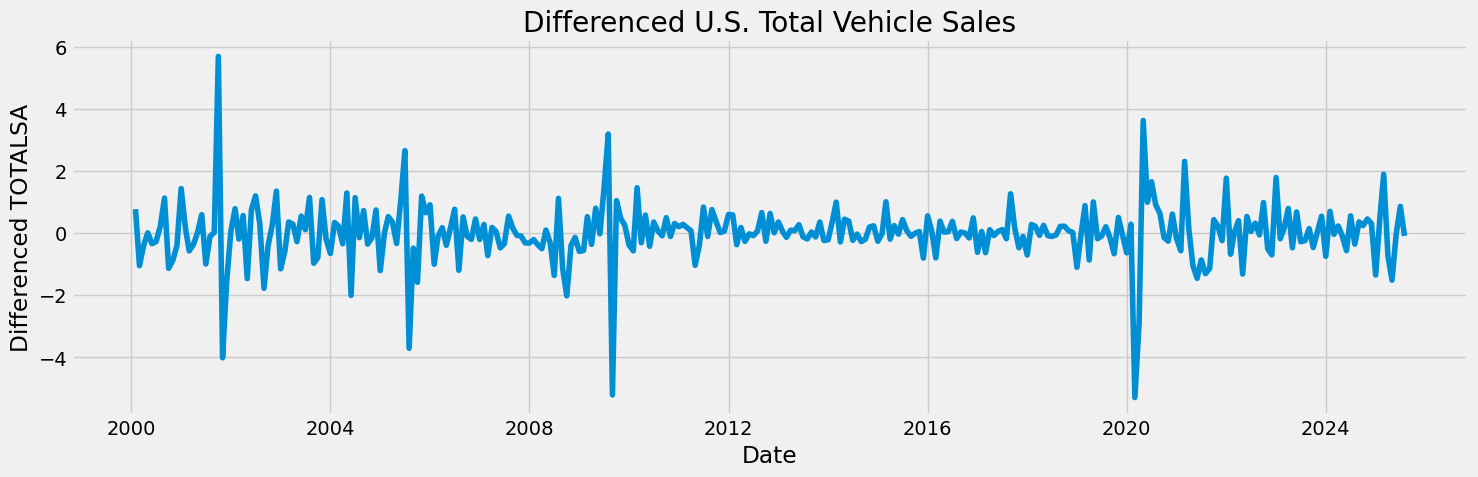

In [28]:
# Check out what the differencing did to the time-series curve

data_diff = data_sub['TOTALSA'].diff().dropna()

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)
plt.title('Differenced U.S. Total Vehicle Sales')
plt.xlabel('Date')
plt.ylabel('Differenced TOTALSA')
plt.tight_layout()

plt.savefig('differenced_series.png', dpi=300)
plt.show()

Interpretation of the Differenced Time Series

After applying differencing to the TOTALSA series, the overall shape of the data changes from a clear trend-driven curve to one that fluctuates around zero. This is expected, because differencing removes long-term trends and stabilizes the mean over time.

From the plot, the differenced values appear much more stationary: the variance looks more consistent, and there are no obvious long-term upward or downward movements. This matches the statistical results from the Dickey–Fuller test, which confirmed stationarity after differencing.

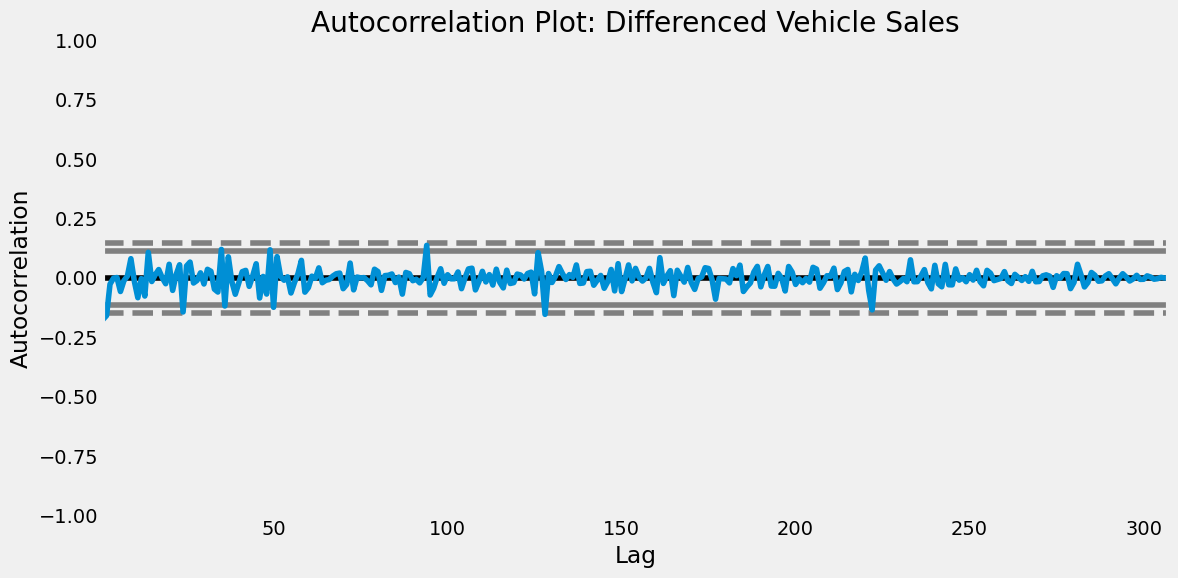

In [30]:
# Check the data’s autocorrelations

from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(12,6), dpi=100)
autocorrelation_plot(data_diff)

plt.title('Autocorrelation Plot: Differenced Vehicle Sales')
plt.tight_layout()

plt.savefig('autocorrelation_plot.png', dpi=300)
plt.show()

**Autocorrelation Analysis**

The autocorrelation plot above shows how the differenced vehicle sales values relate to their past values across multiple time lags. After differencing, the autocorrelations mostly fall within the dashed confidence bands, and they fluctuate closely around zero. This indicates that:

- There is no strong or persistent autocorrelation left in the differenced data.

- The earlier patterns and seasonality have been largely removed.

- The time series appears to behave more randomly, which supports the conclusion that differencing successfully helped achieve stationarity.

7. Bonus task

To begin the ARIMA modeling process, I plotted the autocorrelation (ACF) and partial autocorrelation (PACF) of the differenced vehicle sales dataset (data_diff). These plots help identify appropriate values for the AR (p) and MA (q) components of the ARIMA model.

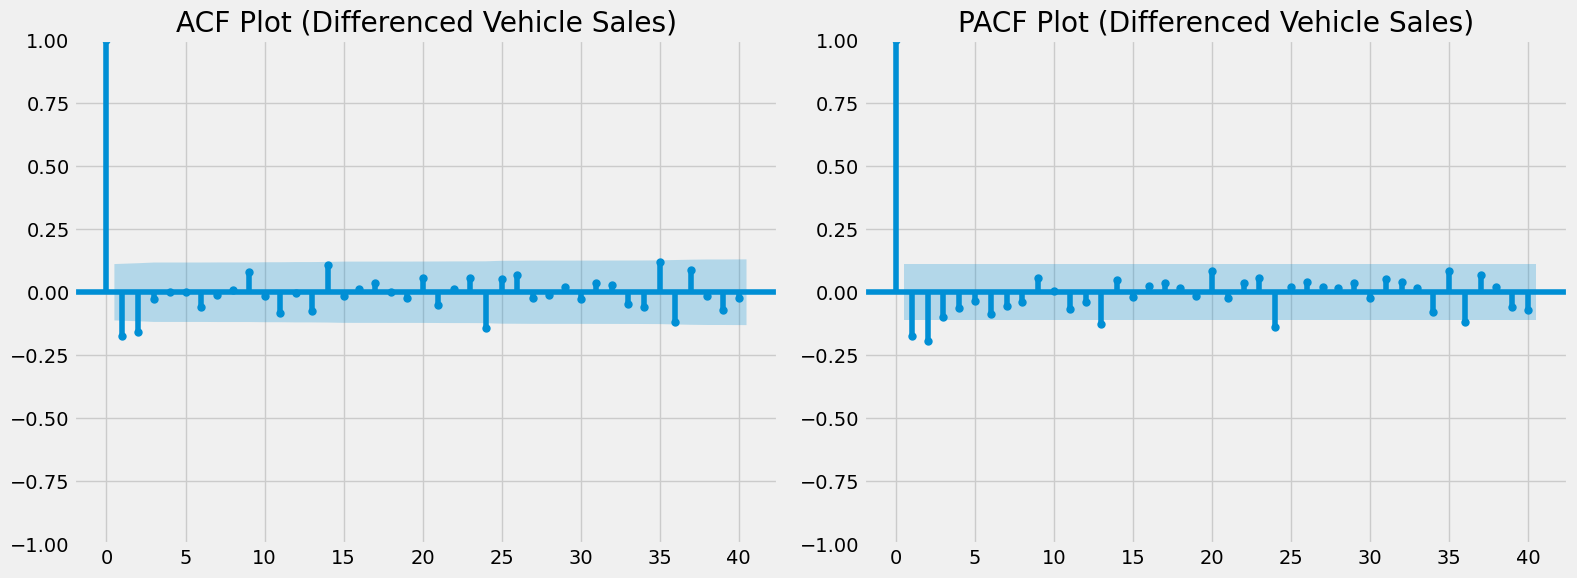

In [31]:
# ACF & PACF plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plot_acf(data_diff, ax=plt.gca(), lags=40)
plt.title("ACF Plot (Differenced Vehicle Sales)")

plt.subplot(1,2,2)
plot_pacf(data_diff, ax=plt.gca(), lags=40, method='ywm')
plt.title("PACF Plot (Differenced Vehicle Sales)")

plt.tight_layout()
plt.savefig("acf_pacf_bonus.png", dpi=300)
plt.show()

Choosing ARIMA Parameters (p, d, q)

To choose the ARIMA model parameters, I used the ACF and PACF plots:

d = 1
Because one round of differencing made the series stationary (DF p-value < 0.05).

PACF plot → AR terms (p)
The PACF plot shows several significant spikes at early lags, so I will start with p = 5, matching the logic used in the course example.

ACF plot → MA terms (q)
The ACF plot shows a few significant lags. I will start with q = 3, again following the example’s conservative choice.

Therefore, my first ARIMA model will use:

ARIMA(p=5, d=1, q=3)

In [32]:
# Train/test split (80/20)
split_index = int(len(data_sub) * 0.8)

train = data_sub['TOTALSA'].iloc[:split_index]
test = data_sub['TOTALSA'].iloc[split_index:]

train.shape, test.shape

((246,), (62,))

I split the dataset into an 80% training set and a 20% test set. This gives enough historical data for the ARIMA model to learn patterns, while still providing a meaningful out-of-sample test.

Training observations: ~80% of the data

Test observations: ~20% of the data

This split is appropriate because:

The test period includes recent volatility (post-COVID), which allows us to evaluate whether ARIMA can handle real-world disruptions.

The training set remains long enough to model cycles and trends.

In [33]:
# First ARIMA iteration (5,1,3)
from statsmodels.tsa.arima.model import ARIMA

model_1 = ARIMA(train, order=(5,1,3))
fitted_1 = model_1.fit()

print(fitted_1.summary())

                               SARIMAX Results                                
Dep. Variable:                TOTALSA   No. Observations:                  246
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -331.658
Date:                Mon, 17 Nov 2025   AIC                            681.316
Time:                        18:46:10   BIC                            712.827
Sample:                    01-01-2000   HQIC                           694.005
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1640     33.219     -0.005      0.996     -65.272      64.944
ar.L2         -0.1297     18.267     -0.007      0.994     -35.933      35.673
ar.L3         -0.0879     15.086     -0.006      0.9

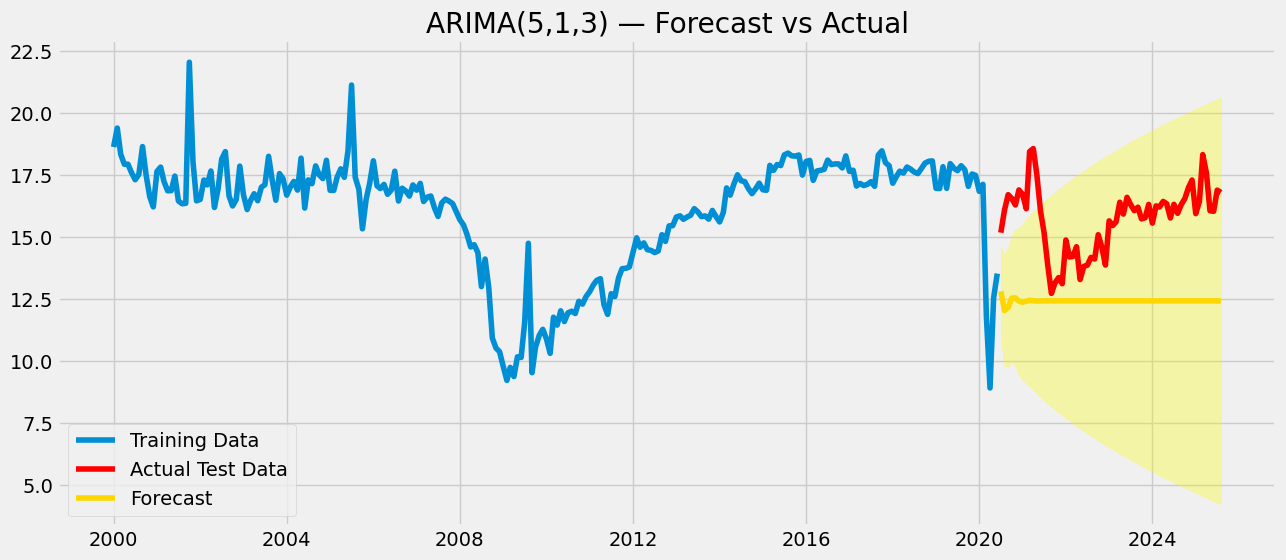

In [34]:
# Plot forecast vs. actual

# Forecast the length of the test set
forecast_1 = fitted_1.get_forecast(steps=len(test))
pred_1 = forecast_1.predicted_mean
ci_1 = forecast_1.conf_int()

plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data', color='red')
plt.plot(test.index, pred_1, label='Forecast', color='gold')

plt.fill_between(test.index, ci_1.iloc[:,0], ci_1.iloc[:,1],
                 color='yellow', alpha=0.3)

plt.legend()
plt.title("ARIMA(5,1,3) — Forecast vs Actual")
plt.savefig("arima_513_forecast.png", dpi=300)
plt.show()

Forecast vs. Actual Values

- The ARIMA forecast becomes almost flat (yellow line).

- The prediction interval (shaded region) widens substantially.

- The model fails to track the upward fluctuations seen in the test data (red line).

To conclude: Although the ARIMA(5,1,3) model runs successfully, its results indicate that it does not fit the vehicle sales data well. The model’s insignificance, non-normal residuals, and flat forecasts show that ARIMA struggles to capture the real dynamics of this time series.

In [35]:
# Second ARIMA attempt (2,1,1)
model_2 = ARIMA(train, order=(2,1,1))
fitted_2 = model_2.fit()

print(fitted_2.summary())

                               SARIMAX Results                                
Dep. Variable:                TOTALSA   No. Observations:                  246
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -332.278
Date:                Mon, 17 Nov 2025   AIC                            672.557
Time:                        19:10:49   BIC                            686.562
Sample:                    01-01-2000   HQIC                           678.196
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1820      0.193      0.942      0.346      -0.197       0.560
ar.L2         -0.1703      0.081     -2.101      0.036      -0.329      -0.011
ma.L1         -0.4823      0.187     -2.578      0.0

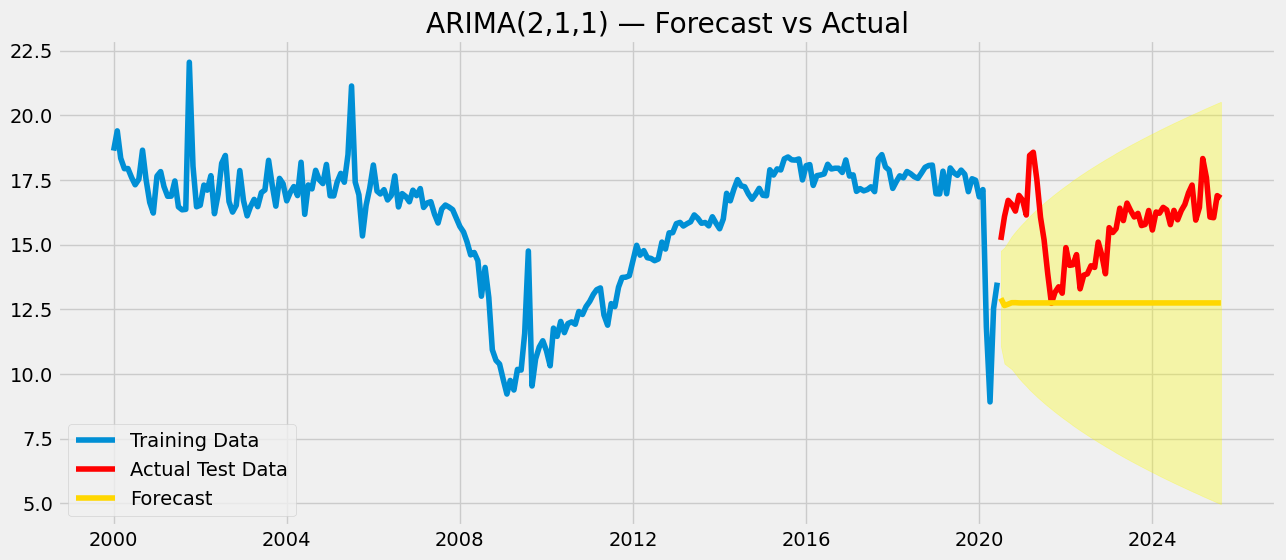

In [36]:
# Forecast the length of the test set
forecast_2 = fitted_2.get_forecast(steps=len(test))
pred_2 = forecast_2.predicted_mean
ci_2 = forecast_2.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data', color='red')
plt.plot(test.index, pred_2, label='Forecast', color='gold')

plt.fill_between(test.index, ci_2.iloc[:,0], ci_2.iloc[:,1],
                 color='yellow', alpha=0.3)

plt.legend()
plt.title("ARIMA(2,1,1) — Forecast vs Actual")
plt.savefig("arima_211_forecast.png", dpi=300)
plt.show()

Second ARIMA Attempt — ARIMA(2,1,1)

After examining the diagnostic results of the first model (ARIMA 5,1,3), it became clear that the majority of AR and MA coefficients were statistically insignificant, and the model produced a nearly flat forecast. This suggested that the model was over-parameterized.

To address this issue, I reduced the complexity and tried a smaller model: ARIMA(2,1,1)

p = 2 (because PACF showed only weak significance beyond lag 2)

d = 1 (data became stationary after one differencing)

q = 1 (ACF showed one meaningful early spike)

The ARIMA(2,1,1) model performs better than the previous model but still fails to capture the full complexity of the Total Vehicle Sales data. Economic series with structural breaks, crises, and sudden shocks tend to be difficult for basic ARIMA models to forecast accurately.

In [37]:
# Third ARIMA attempt (1,1,2)
model_3 = ARIMA(train, order=(1,1,2))
fitted_3 = model_3.fit()

print(fitted_3.summary())

                               SARIMAX Results                                
Dep. Variable:                TOTALSA   No. Observations:                  246
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -332.877
Date:                Mon, 17 Nov 2025   AIC                            673.755
Time:                        19:16:29   BIC                            687.760
Sample:                    01-01-2000   HQIC                           679.394
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0018      0.326     -0.005      0.996      -0.641       0.637
ma.L1         -0.3006      0.322     -0.932      0.351      -0.932       0.331
ma.L2         -0.1957      0.121     -1.615      0.1

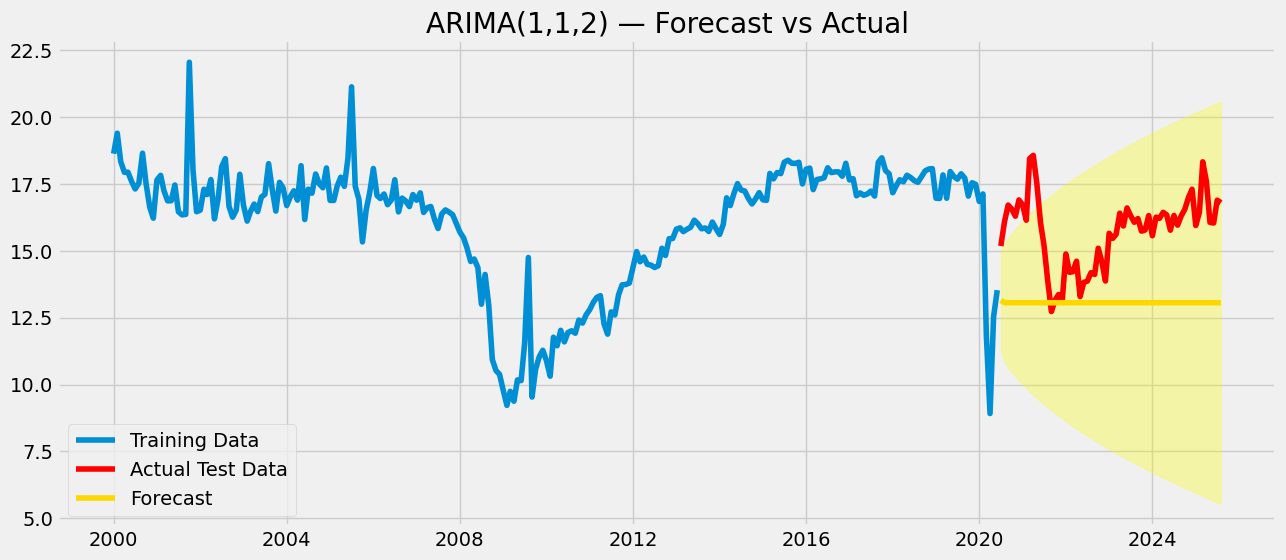

In [38]:
# Forecast for the length of the test set
forecast_3 = fitted_3.get_forecast(steps=len(test))
pred_3 = forecast_3.predicted_mean
ci_3 = forecast_3.conf_int()

plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data', color='red')
plt.plot(test.index, pred_3, label='Forecast', color='gold')

plt.fill_between(test.index,
                 ci_3.iloc[:,0],
                 ci_3.iloc[:,1],
                 color='yellow', alpha=0.3)

plt.legend()
plt.title("ARIMA(1,1,2) — Forecast vs Actual")
plt.savefig("arima_112_forecast.png", dpi=300)
plt.show()

For my third ARIMA attempt, I tested an ARIMA(1,1,2) model. This configuration was chosen because the PACF plot suggested one meaningful AR term, while the ACF showed two MA spikes. This makes (1,1,2) a reasonable next step after the weaker performance of ARIMA(5,1,3) and ARIMA(2,1,1).


From the forecast plot:

- The forecast line is still flat, similar to the previous models.

- The model does not capture the upward movement and variability in the test period.

- The confidence interval expands widely over time, which suggests high uncertainty.

- The forecast fails to follow the fluctuations shown in the actual test data (red line).

**Interpretation**

Although ARIMA(1,1,2) simplifies the structure and avoids overfitting, it still struggles to model real-world vehicle sales, especially during the volatile post-2020 period. This makes sense because ARIMA models typically perform best with stable, repeating patterns. Vehicle sales, however, show sudden shocks (e.g., recession, supply chain issues, COVID-19), which are difficult for ARIMA to capture.

**Conclusion**

ARIMA(1,1,2) still does not provide an accurate or realistic forecast. Its flat predictions and wide confidence intervals show that:

- ARIMA alone may not be suitable for this dataset.

- The series is strongly affected by events ARIMA cannot learn.

A different modeling approach may be needed for meaningful forecasting.